In [2]:
import numpy as np
from emotion_recognition import utils
from emotion_recognition import features

import essentia
import essentia.streaming
from essentia.standard import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

import tensorflow as tf
import time

## 1. 파일 이름 읽어오기

- training data

In [4]:
path = "data/"

training_text = "training.txt"

wav_filename_list = []
emotion_list = []
text_list = []

f = open(path+training_text,'r')

while True:
    line = f.readline()
    
    if not line: break
    
    filename, text, emotion = line.split('\t')
    
    if emotion[-1] == "\n":
        emotion = emotion[:-1]
        
    wav_filename_list.append(filename.replace('\\','/'))
    emotion_list.append(emotion)
    text_list.append(text)
    
f.close()

In [5]:
window_size = 250 # 특징 추출을 위한 윈도우 크기
n_mfcc = 13 #MFCC 계수 크기
frame_size = 500 # 음성구간 찾기 위한 프레임 크기
time_step = 78 # RNN time step
feature_size = 43 # 전체 특징 길이
class_size = 4 #class 크기
sr = 16000

emotions = ["Neutrality", "Anger", "Happiness", "Sadness"]

In [6]:
#Module Initialization for Essentia
spectrum = Spectrum()
window = Windowing(type='hann')
pitch = PitchYin(sampleRate = sr, frameSize = window_size)
specPeak = SpectralPeaks(minFrequency=20, maxFrequency = 8000, sampleRate = sr)
harPeak = HarmonicPeaks()

In [7]:
Training_vector = []
Training_label = []

for ix in range(len(wav_filename_list)):
    # 파일 읽어오기
    print (str(ix)+ "\t" + emotion_list[ix] + "\t\t" + path + wav_filename_list[ix])
    
    y,sr = utils.loadwav(path + wav_filename_list[ix])
    
    #파일 전체 길이
    length = len(y)
    
    idx = 0
    while(idx != length):
        #하나의 구간에 대하여 Feature_list를 만들기  
        Feature_list = []
        feature_set_cnt = 0
        
        #voice 구간 구하기
        IAV_th = utils.get_IAV_threshold(y,length,frame_size)
        th = IAV_th/frame_size*2
        
        start_point, end_point = utils.search_voicearea(y,frame_size,length,idx,th,IAV_th)
            
        if(start_point == -1):
            break
            
        idx = end_point
        
        segment_length = end_point-start_point+1
        # 음성 구간이 time_step 보다 짧으면 해당 음성 구간에서 특징 추출 x
        if(segment_length-window_size < (time_step*window_size)):
            continue
            
        
        # 특징 추출    
        for i in range(start_point,(end_point-window_size),window_size): #윈도우 사이즈 만큼 잘라서
            y_sub = y[i:i+window_size]
            Feature_Set = []
            
            #MFCC
            mfcc_c = features.MFCC(y_sub,sr,window_size,n_mfcc)
            for j in range(len(mfcc_c)):
                Feature_Set = Feature_Set + mfcc_c[j].tolist() # array list로 바꿔서 뒤에 리스트 안에 있는 요소 덧붙이기
            
            #Spectral feature 
            # 1. centroid(happy) : 1
            cent = features.spectral_centroid(y_sub,sr,window_size)
            Feature_Set.append(cent)
                
            # 2. bandwidth : 1
            bandwidth = features.spectral_bandwidth(y_sub,sr,window_size)
            Feature_Set.append(bandwidth)

            # 3. contrast : 7
            contrast = features.spectral_contrast(y_sub,sr,window_size)    
            for j in range(len(contrast)):
                Feature_Set = Feature_Set + contrast[j].tolist()

            # 4. flatness : 1
            flatness = features.spectral_flatness(y_sub,sr,window_size)
            Feature_Set.append(flatness)

            # 5. rolloff : 1
            rolloff = features.spectral_rolloff(y_sub,sr,window_size)
            Feature_Set.append(rolloff)
            
            # Chroma : 12
            chroma_vec = features.chroma(y_sub,sr,window_size)    
            for j in range(len(chroma_vec)):
                Feature_Set = Feature_Set + chroma_vec[j].tolist()
            
            
            # harmonic feature
            #Pitch function returns pitch data(pitch_out) and pitch_confidence
            #If pitch_confidence equal to zero, it means that pitch data is not found in current frame
            pitch_out, pitch_confidence = pitch(y_sub)
            if pitch_confidence==0:
                pitch_out = 0

            #Spectrum of current frame is used to extract spectral peak feature
            #Spectral frequency and spectral magnitude will be returned
            specfrequency, specmagnitude = specPeak(spectrum(y_sub))

            #Spectral frequency, spectral magnitude, and pitch data are used to extract harmonic peak feature
            #Harmonic frequency and harmonic magnitude will be returned
            harfrequency, harmagnitude = harPeak(specfrequency, specmagnitude, pitch_out)

            # 1, inharmonicity(fear) : 1
            inharmonicity  = features.inharmonicity(harfrequency,harmagnitude)
            Feature_Set.append(inharmonicity)
            
            # 2.  tristimulus : 3
            tristimulus1, tristimulus2, tristimulus3 = features.tristimulus(harfrequency,harmagnitude)
            Feature_Set.append(tristimulus1)
            Feature_Set.append(tristimulus2)
            Feature_Set.append(tristimulus3)
            
            # 3. harmonic_energy(anger) : 1
            harEnergy = features.harEnergy(harfrequency,harmagnitude)
            Feature_Set.append(harEnergy)

            # 4. noiseEnergy(sadness) : 1
            noiseEnergy = features.noiseEnergy(spectrum(y_sub),harEnergy)
            Feature_Set.append(noiseEnergy)
            
            # 5. noiseness(neutral) : 1
            noiseness = features.noiseness(spectrum(y_sub),harEnergy)
            Feature_Set.append(noiseness)
            
            Feature_list.append(Feature_Set)
            feature_set_cnt = feature_set_cnt + 1
            
        ## Training_vector 생성 (구간갯수, 구간에서의 feature set 갯수, feature 갯수)
        if not Feature_list:
            print("empty")
        else:    
            Training_vector.append(Feature_list)
            Training_label.append(emotions.index(emotion_list[ix]))

0	Anger		data/wav/Anger_695.wav


/home/pmp/anaconda3/envs/tensorflow2/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=250
  n_fft, y.shape[-1]
/home/pmp/anaconda3/envs/tensorflow2/lib/python3.6/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


1	Anger		data/wav/Anger_151.wav
2	Anger		data/wav/Anger_319.wav
3	Neutrality		data/wav/Neutrality_513.wav
4	Neutrality		data/wav/Neutrality_611.wav
5	Happiness		data/wav/Happiness_313.wav
6	Neutrality		data/wav/Neutrality_295.wav
7	Anger		data/wav/Anger_403.wav
8	Anger		data/wav/Anger_650.wav
9	Happiness		data/wav/Happiness_240.wav
10	Anger		data/wav/Anger_412.wav
11	Happiness		data/wav/Happiness_88.wav
12	Happiness		data/wav/Happiness_23.wav
13	Anger		data/wav/Anger_583.wav
14	Sadness		data/wav/Sadness_315.wav


KeyboardInterrupt: 

In [9]:
len(chroma_vec)

12

- test data

In [42]:
path = "data/"

test_text = "text.txt"

wav_filename_list = []
emotion_list = []
text_list = []

f = open(path+test_text,'r')

while True:
    line = f.readline()
    
    if not line: break
    
    filename, text, emotion = line.split('\t')
    
    if emotion[-1] == "\n":
        emotion = emotion[:-1]
        
    wav_filename_list.append(filename.replace('\\','/'))
    emotion_list.append(emotion)
    text_list.append(text)
    
f.close()

In [43]:
print(wav_filename_list)

['wav/Anger_819.wav', 'wav/Neutrality_796.wav', 'wav/Neutrality_1615.wav', 'wav/Neutrality_1037.wav']


In [44]:
Test_vector = []
Test_label = []

for ix in range(len(wav_filename_list)):
    # 파일 읽어오기
    print (str(ix)+ "\t" + emotion_list[ix] + "\t\t" + path + wav_filename_list[ix])
    
    y,sr = utils.loadwav(path + wav_filename_list[ix])
    
    #파일 전체 길이
    length = len(y)
    
    idx = 0
    while(idx != length):
        #하나의 구간에 대하여 Feature_list를 만들기  
        Feature_list = []
        feature_set_cnt = 0
        
        #voice 구간 구하기
        IAV_th = utils.get_IAV_threshold(y,length,frame_size)
        th = IAV_th/frame_size*2
        
        start_point, end_point = utils.search_voicearea(y,frame_size,length,idx,th,IAV_th)
            
        if(start_point == -1):
            break
            
        idx = end_point
        
        segment_length = end_point-start_point+1
        # 음성 구간이 time_step 보다 짧으면 해당 음성 구간에서 특징 추출 x
        if(segment_length-window_size < (time_step*window_size)):
            print("too short")
            continue
            
        
        # 특징 추출    
        for i in range(start_point,(end_point-window_size),window_size):
            y_sub = y[i:i+window_size]
            Feature_Set = []
            
            #MFCC
            mfcc_c = features.MFCC(y_sub,sr,window_size,n_mfcc)
            for j in range(len(mfcc_c)):
                Feature_Set = Feature_Set + mfcc_c[j].tolist()
            
            #Spectral feature
            # 1. centroid
            cent = features.spectral_centroid(y_sub,sr,window_size)
            Feature_Set.append(cent)
                
            # 2. bandwidth
            bandwidth = features.spectral_bandwidth(y_sub,sr,window_size)
            Feature_Set.append(bandwidth)

            # 3. contrast
            contrast = features.spectral_contrast(y_sub,sr,window_size)    
            for j in range(len(contrast)):
                Feature_Set = Feature_Set + contrast[j].tolist()

            # 4. flatness
            flatness = features.spectral_flatness(y_sub,sr,window_size)
            Feature_Set.append(flatness)

            # 5. rolloff
            rolloff = features.spectral_rolloff(y_sub,sr,window_size)
            Feature_Set.append(rolloff)
            
            # Chroma
            chroma_vec = features.chroma(y_sub,sr,window_size)    
            for j in range(len(chroma_vec)):
                Feature_Set = Feature_Set + chroma_vec[j].tolist()
            
            
            # harmonic feature
            #Pitch function returns pitch data(pitch_out) and pitch_confidence
            #If pitch_confidence equal to zero, it means that pitch data is not found in current frame
            pitch_out, pitch_confidence = pitch(y_sub)
            if pitch_confidence==0:
                pitch_out = 0

            #Spectrum of current frame is used to extract spectral peak feature
            #Spectral frequency and spectral magnitude will be returned
            specfrequency, specmagnitude = specPeak(spectrum(y_sub))

            #Spectral frequency, spectral magnitude, and pitch data are used to extract harmonic peak feature
            #Harmonic frequency and harmonic magnitude will be returned
            harfrequency, harmagnitude = harPeak(specfrequency, specmagnitude, pitch_out)

            # 1. inharmonicity
            inharmonicity  = features.inharmonicity(harfrequency,harmagnitude)
            Feature_Set.append(inharmonicity)
            
            # 2.  tristimulus
            tristimulus1, tristimulus2, tristimulus3 = features.tristimulus(harfrequency,harmagnitude)
            Feature_Set.append(tristimulus1)
            Feature_Set.append(tristimulus2)
            Feature_Set.append(tristimulus3)
            
            # 3. harmonic_energy
            harEnergy = features.harEnergy(harfrequency,harmagnitude)
            Feature_Set.append(harEnergy)

            # 4. noiseEnergy
            noiseEnergy = features.noiseEnergy(spectrum(y_sub),harEnergy)
            Feature_Set.append(noiseEnergy)
            
            # 5. noiseness
            noiseness = features.noiseness(spectrum(y_sub),harEnergy)
            Feature_Set.append(noiseness)
            
            Feature_list.append(Feature_Set)
            feature_set_cnt = feature_set_cnt + 1
            
        ## Test_vector 생성 (구간갯수, 구간에서의 feature set 갯수, feature 갯수)
        if not Feature_list:
            print("empty")
        else:    
            Test_vector.append(Feature_list)
            Test_label.append(emotions.index(emotion_list[ix]))

0	Anger		data/wav/Anger_819.wav
1	Neutrality		data/wav/Neutrality_796.wav
2	Neutrality		data/wav/Neutrality_1615.wav
3	Neutrality		data/wav/Neutrality_1037.wav


In [45]:
print(len(Test_vector))

4


In [46]:
print(np.shape(Test_vector[0]))
print(np.shape(Test_vector[1]))
print(np.shape(Test_vector[2]))

(215, 43)
(85, 43)
(98, 43)


In [13]:
np.shape(Training_vector[0])

(204, 43)

In [15]:
#np.shape(Training_vector[1])
np.shape(Training_vector[2])

(114, 43)

## 2. 데이터 정리

- Training vector

In [12]:
tx = []
ty = []

for i in range(len(Training_vector)):
    for j in range(0,len(Training_vector[i])-time_step+1,30):
        temp = Training_vector[i][j:j+time_step]
        tx.append(temp)
        ty.append(Training_label[i])

print (np.shape(tx),np.shape(ty))

(3901, 78, 43) (3901,)


In [13]:
X=np.array(tx)
y=np.array(ty)
y = np.reshape(y, (y.shape[0], 1))

In [14]:
X_train = np.array(tx)
Y_train = np.array(ty)

random_index = np.arange(np.shape(X_train)[0])
np.random.shuffle(random_index)

X_train = X_train[random_index]
Y_train = Y_train[random_index]

In [15]:
print (np.shape(X_train))
print (np.shape(Y_train))

(3901, 78, 43)
(3901,)


In [16]:
X_train = np.array(X_train)
Y_train = label_binarize(Y_train, classes = list(range(class_size)))
Y_train = np.array(Y_train)

- Test vector

In [17]:
tx = []
ty = []

for i in range(len(Test_vector)):
    for j in range(0,len(Test_vector[i])-time_step+1,30): # 30씩 겹치도록 
        temp = Test_vector[i][j:j+time_step]
        tx.append(temp)
        ty.append(Test_label[i])

print (np.shape(tx),np.shape(ty))

(2433, 78, 43) (2433,)


In [18]:
X=np.array(tx)
y=np.array(ty)
y = np.reshape(y, (y.shape[0], 1))

In [19]:
X_test = np.array(tx)
Y_test = np.array(ty)

In [20]:
print (np.shape(X_test))
print (np.shape(Y_test))

(2433, 78, 43)
(2433,)


In [21]:
X_test = np.array(X_test)
Y_test =  label_binarize(Y_test, classes = list(range(class_size)))
Y_test = np.array(Y_test)

- Z normalization

In [22]:
x_for_scaling = []
avg = []
std = []

# training feature를 43개의 각 feature 별로 
for i in range(feature_size):
    temp =[]
    x_for_scaling.append(temp)
    
for i in range(len(X_train)):
    for j in range(len(X_train[i])):
        for k in range(len(X_train[i][j])):
            x_for_scaling[k].append(X_train[i][j][k])

#각 feature의 평균과 표준편차를 구함
for i in range(len(x_for_scaling)):
    avg.append(np.mean(x_for_scaling[i]))
    std.append(np.std(x_for_scaling[i]))
    
# training 벡터 nomarlization
for i in range(len(X_train)):
    for j in range(len(X_train[i])):
        for k in range(len(X_train[i][j])):
            X_train[i][j][k] = (X_train[i][j][k] - avg[k])/std[k] 
            
#test 벡터 nomarlization
for i in range(len(X_test)):
    for j in range(len(X_test[i])):
        for k in range(len(X_test[i][j])):
            X_test[i][j][k] = (X_test[i][j][k] - avg[k])/std[k] 

In [23]:
print (avg)

[-1547.828344299747, 164.46551110807079, 85.18688135405077, 45.43834209509118, 15.881591280754723, 18.628239017359125, -2.4040261601779704, 4.321289439492613, -1.7937067352293998, -3.193358810835332, -7.529066887670656, -16.984289046557986, -8.741670870624096, 1838.5094395570368, 1988.3619675446114, 4.928205352522378, 7.659041372888939, 11.073215926075795, 15.370925883963068, 19.93438905748131, 24.475064904622478, 17.753413799274092, 0.02037535811613401, 2426.6810745436737, 0.6772143002492703, 0.6372629913833573, 0.6098420968155306, 0.5984496512694096, 0.603969240791121, 0.6094043538322268, 0.6277062512862338, 0.6553106766640437, 0.6539609169945031, 0.6605020201414982, 0.6732662760167458, 0.6888473029956301, 0.046774348483142915, 0.5379861083738202, 0.25918900825482166, 0.19221287726834324, 85459224124.98347, 29651010733.60391, 0.3765028065712457]


In [24]:
print (std)

[168.1483039274775, 108.58528604222126, 78.32093605063436, 72.15455310748264, 56.56792398277041, 47.799993891065995, 40.72160755427375, 36.10325414377614, 32.07338601832062, 28.238300235540436, 25.80581362955083, 25.994767351542173, 24.166530780637952, 1482.7804693493197, 672.8898293539447, 4.581305948719422, 4.995788189306767, 5.520749161447816, 6.190193152525389, 6.310636112490528, 6.4282477990178775, 6.893697264686665, 0.046461875574186816, 1945.5705387666642, 0.2871937679012355, 0.2549316494768003, 0.23778517242977096, 0.22788436187910238, 0.23065916798023853, 0.24286622024532595, 0.2741259502679129, 0.29397020731831447, 0.2770207375103381, 0.2649778146972901, 0.2683126162510197, 0.2845018975748724, 0.07260678829528673, 0.3030274608140964, 0.21041915954588017, 0.17333707238856366, 124773466606.82458, 44475273698.17101, 0.2609389911207921]


In [26]:
batch_size = 50
epochs = 100

In [50]:
import tensorflow as tf

In [52]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential()
#model.add(layers.LSTM(32, dropout=0.1, recurrent_dropout = 0.5, input_shape = (time_step, feature_size)))
model.add(tf.keras.layers.LSTM(64, dropout=0.5, recurrent_dropout = 0.5, return_sequences = True, input_shape = (time_step, feature_size)))
model.add(tf.keras.layers.LSTM(32,dropout=0.5, recurrent_dropout=0.5))
model.add(tf.keras.layers.Dense(128, activation='softmax'))
model.add(tf.keras.layers.Dense(class_size, kernel_regularizer= tf.keras.regularizers.l2(0.001), activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 78, 64)            27648     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 128)               4224      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 44,804
Trainable params: 44,804
Non-trainable params: 0
_________________________________________________________________


In [53]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train,Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test,Y_test))

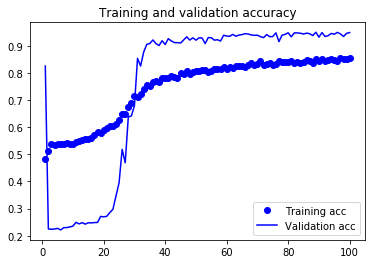

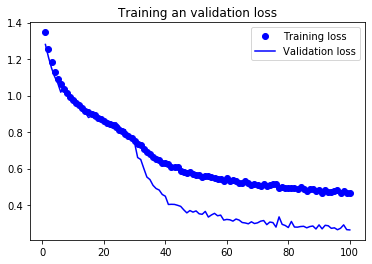

In [29]:
import matplotlib.pyplot as plt

acc = history.history["acc"]
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs= range(1,len(acc)+1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss,'b',label = 'Validation loss')
plt.title('Training an validation loss')
plt.legend()

plt.show()

In [31]:
test_loss,test_acc = model.evaluate(X_test,Y_test)

2433/2433 [==============================] - 2s 1ms/sample - loss: 0.2644 - acc: 0.9486


In [32]:
print (test_acc)

0.9486231


In [54]:
model.save("LSTM_dropout_class3_timestep78_feature43.h5")